<a href="https://colab.research.google.com/github/Ssurf777/VAE_sample/blob/main/outside_pinn/cVAE_load_make_gif_anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 保存済みの重みファイルをロードして可視化する方法

In [ ]:

import os
import numpy as np
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms, utils

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd

In [ ]:
import numpy as np
import plotly.graph_objs as go

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []

    def rotate_z(x, y, z, theta):
        w = x + 1j * y
        return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))

    fig = go.Figure(
        data=data,
        layout=go.Layout(
            updatemenus=[dict(
                type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(
                        frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                    )]
                )]
            )],
        ),
        frames=frames
    )
    return fig

def pcshow(xs, ys, zs):
    data = [go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(
        marker=dict(
            size=2,
            line=dict(
                width=2,
                color='DarkSlateGrey'
            )
        ),
        selector=dict(mode='markers')
    )
    fig.show()


In [ ]:
# 内挿域サンプリング
class PointSampler(object):
  def __init__(self, output_size):
    assert isinstance(output_size, int)
    self.output_size = output_size

  def triangle_area(self, pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * (side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

  def sample_point(self, pt1, pt2, pt3):
    s, t = sorted([random.random(),random.random()])
    f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
    return (f(0), f(1), f(2))

  def __call__(self,mesh):
    verts, faces = mesh
    verts = np.array(verts)
    areas = np.zeros((len(faces)))

    for i in range(len(areas)):
      areas[i] = (self.triangle_area(verts[faces[i][0]],
                                     verts[faces[i][1]],
                                     verts[faces[i][2]]))
      sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
      sampled_points = np.zeros((self.output_size,3))
    for i in range(len(sampled_faces)):
      sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                             verts[sampled_faces[i][1]],
                                             verts[sampled_faces[i][2]]))
    return sampled_points

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

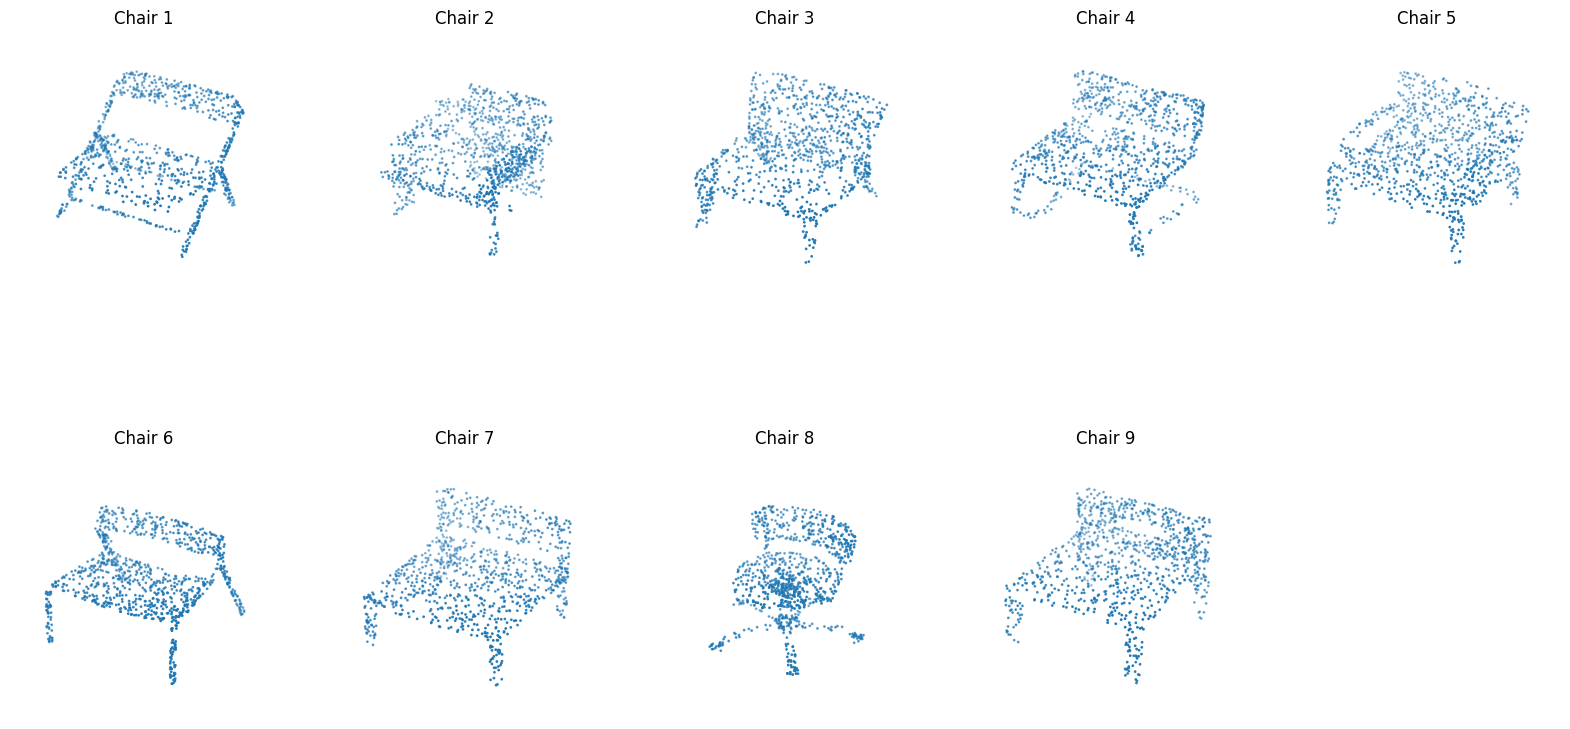

In [ ]:
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,10)]

input_data_list = []
input_data_list2 = []

for file_name in file_names:
  with open(file_name, 'r') as f:
    verts, faces = read_off(f)

    i,j,k = np.array(faces).T
    x,y,z = np.array(verts).T

    pointcloud = PointSampler(1000)((verts,faces))

    # traindata
    train_x = pointcloud[:,0]
    train_y = pointcloud[:,1]
    train_z = pointcloud[:,2]

    # 正規化
    train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
    train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
    train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())

    # data combine
    combined_data = np.concatenate((train_xn,train_yn,train_zn))

    # input data
    input_data_list.append(combined_data)
    combined_data2 = np.vstack((train_xn, train_yn, train_zn)).T
    input_data_list2.append(combined_data2)

  input_data = np.stack(input_data_list)
  #input_tensor = torch.tensor(input_data, dtype=torch.float32).cuda()
  input_tensor = torch.tensor(input_data, dtype=torch.float32)
  batch_size = 1
  dataset = TensorDataset(input_tensor)
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)


  # 可視化
fig = plt.figure(figsize=(20, 10))

for i, pointcloud in enumerate(input_data_list2):
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], s=1)
    ax.set_title(f'Chair {i+1}')
    ax.axis('off')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# training setting
eta = 0.0001
epochs = 1000
batch_size = 1
interval = 10

num_points = 1000
n_in_out = 3 * num_points
n_mid1 = 512
n_mid2 = 256
n_mid3 = 128
n_mid4 = 64
n_mid5 = 32
n_z = 2  # 潜在変数の数
con_dim = 1  # 条件次元（任意で変更）
con_z_values = [0.5, 0.75, 1.0]  # 3つの水準値

class conVAE(nn.Module):
    def __init__(self):
        super(conVAE, self).__init__()

        # PointNet Encoder
        self.conv1 = nn.Conv1d(n_in_out, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 9)
        self.enc_mu = nn.Linear(9, n_z)
        self.enc_logvar = nn.Linear(9, n_z)

        # Decoder
        self.dec1 = nn.Linear(n_z + con_dim, n_mid5)  # 修正: con_zも考慮
        self.dec2 = nn.Linear(n_mid5, n_mid4)
        self.dec3 = nn.Linear(n_mid4, n_mid3)
        self.dec4 = nn.Linear(n_mid3, n_mid2)
        self.dec5 = nn.Linear(n_mid2, n_mid1)
        self.dec_out = nn.Linear(n_mid1, n_in_out)

        # Weight initialization
        self._init_weights()

    def forward(self, x, con_z):  # con_zも渡すように変更
        z, mu, logvar = self.encode(x)
        y = self.decode(z, con_z)
        return y, z

    def encode(self, x):
        x = x.reshape(1, n_in_out, 1)
        x = F.leaky_relu(self.conv1(x), negative_slope=0.001)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.001)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.001)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # フラット化してlinear層に接続
        x = F.leaky_relu(self.linear1(x), negative_slope=0.001)
        x = F.leaky_relu(self.linear2(x), negative_slope=0.001)
        x = self.linear3(x)
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        std = torch.exp(0.5 * logvar)  # sigma
        eps = torch.randn_like(std)  # 正規分布に従う乱数
        z = mu + std * eps  # 潜在変数
        self.mu = mu
        self.logvar = logvar
        return z, mu, logvar

    def decode(self, z, con_z):
      # 修正: con_zの次元をzに揃える
      #con_z = con_z.unsqueeze(-1)  # con_zの次元を (batch_size, 1) にする
      #con_z = con_z.expand(z.size(0), z.size(1))  # con_zの次元を (batch_size, latent_dim) に揃える
      z = z.squeeze(0)
      # Latent Space Zとcon_zを結合
      z = torch.cat([z, con_z], dim=-1)  # 次元を一致させてから結合

      # 結合後の形状を確認
      #print(f"Shape of z after concatenation: {z.shape}")
      x = F.leaky_relu(self.dec1(z), negative_slope=0.001)
      x = F.leaky_relu(self.dec2(x), negative_slope=0.001)
      x = F.leaky_relu(self.dec3(x), negative_slope=0.001)
      x = F.leaky_relu(self.dec4(x), negative_slope=0.001)
      x = F.leaky_relu(self.dec5(x), negative_slope=0.001)
      x = self.dec_out(x)  # 最終的な出力層
      return x


    def clipped_pena_loss(self, T_pred, con_z):
        T_max = 1.0  # 最大値（適宜調整）
        T_pena = con_z * T_max  # 上限値の設定
        # T_predがT_pena(上限)を超える場合のペナルティを追加
        penalty = torch.relu(T_pred - T_pena) ** 2
        # T_predやペナルティの値を表示
        #print(f"T_pred: {T_pred[i].unsqueeze(0)}")
        #print(f"T_pena: {T_pena}")
        #print(f"Penalty: {penalty}")
        loss = torch.mean(penalty)

        return loss

    def connectivity_loss(self, y):
        # yを(3, N)の形に変換し、x, y, zそれぞれを取り出す
        y = y.view(-1, 3)  # (N, 3)に変換
        dist_matrix = torch.cdist(y, y, p=2)
        threshold = 0.05
        mask = dist_matrix < threshold
        masked_distances = dist_matrix * mask.float()
        connectivity_loss = torch.mean(masked_distances) * 1 # 1scaled factor
        return connectivity_loss


    def loss(self, y, x, con_z):
        # xを(batch_size, 3)の形に変換
        x_reordered = y.view(3, -1).transpose(0, 1)
        # PINN model Prediction
        T_pred = pinn(x_reordered)

        # clip_loss を1点ずつ算出して合計
        clip_loss = 0
        for i in range(T_pred.size(0)):  # T_pred の各点に対してループを回す
            clip_loss += self.clipped_pena_loss(T_pred[i].unsqueeze(0), con_z)  # 修正: con_zを追加

        rec_loss = F.mse_loss(y, x, reduction="sum")  # 再構成誤差をMSEで計算
        reg_loss = 0.5 * torch.sum(self.mu ** 2 + torch.exp(self.logvar) - self.logvar - 1)  # 正則化項
        conne_loss = self.connectivity_loss(y)
        return rec_loss, reg_loss, clip_loss, conne_loss

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

vae = conVAE()
print(vae)
# vae.cuda()


conVAE(
  (conv1): Conv1d(3000, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=9, bias=True)
  (enc_mu): Linear(in_features=9, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=9, out_features=2, bias=True)
  (dec1): Linear(in_features=3, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=3000, bias=True)
)


In [ ]:
vae.load_state_dict(torch.load('/content/drive/MyDrive/chair/outsidepinn_conne_clip_loss_cvae_weights_1005.pth'))
print("Model weights have been loaded!")


<ipython-input-7-7d27abcca784>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('/content/drive/MyDrive/chair/outsidepinn_conne_clip_loss_cvae

Model weights have been loaded!


In [ ]:
vae.eval()
#data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
#print(input_data_list2)
pointcloud=0
z_list=0

input_data_list3=torch.tensor(input_data_list2).float()
for i, pointcloud in enumerate(input_data_list3):
    indata = torch.tensor(pointcloud).float()  # float32に変換
    #indata = pointcloud.float()
    z_list = vae.encode(indata)
    print(z_list[0])


tensor([[-0.2539,  0.3169]], grad_fn=<AddBackward0>)
tensor([[-0.2840,  0.1943]], grad_fn=<AddBackward0>)
tensor([[-0.4490,  0.2925]], grad_fn=<AddBackward0>)
tensor([[-0.2389,  0.3695]], grad_fn=<AddBackward0>)
tensor([[0.0690, 0.2618]], grad_fn=<AddBackward0>)
tensor([[-0.3523,  0.2735]], grad_fn=<AddBackward0>)
tensor([[-0.0457,  0.2870]], grad_fn=<AddBackward0>)
tensor([[-0.2053,  0.2330]], grad_fn=<AddBackward0>)
tensor([[-0.2779,  0.3167]], grad_fn=<AddBackward0>)


<ipython-input-20-1c5cc1aab842>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indata = torch.tensor(pointcloud).float()  # float32に変換


tensor([[ 1.6321, -1.4126]])
tensor([[-2.1358,  0.5923]])
tensor([[ 1.2719, -0.1939]])
tensor([[1.1244, 0.7506]])
tensor([[-0.1163,  0.2301]])
tensor([[-1.6709, -0.8260]])
tensor([[-1.0747,  1.4682]])
tensor([[-0.2253, -0.9015]])
tensor([[0.6490, 2.1788]])


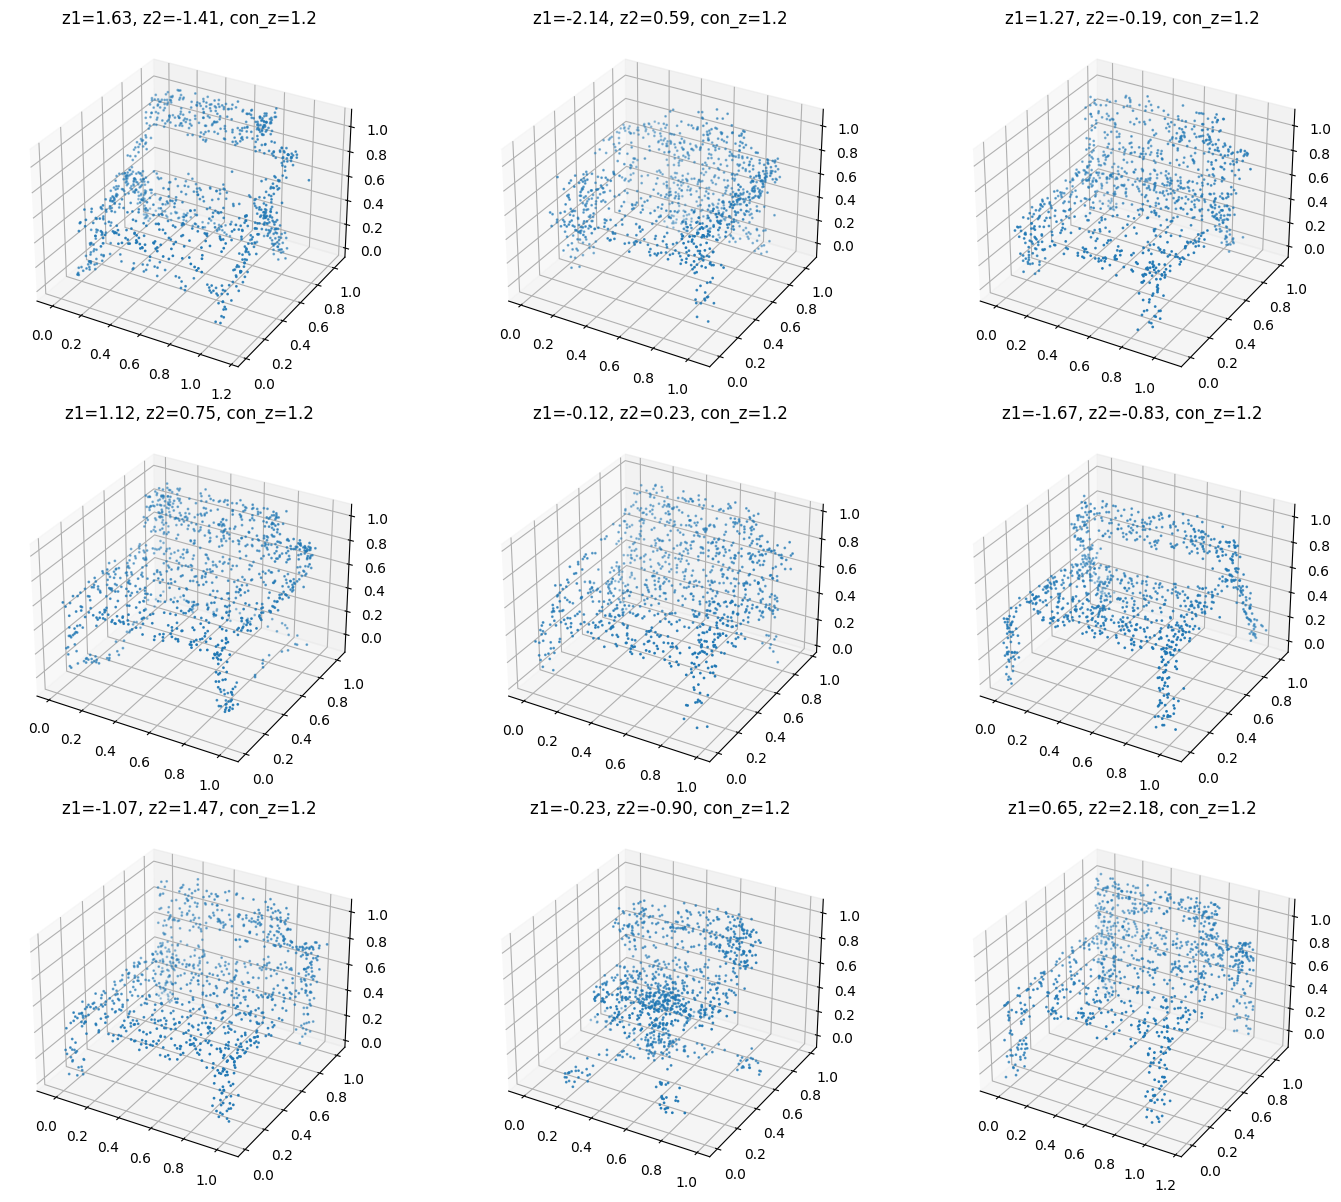

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 潜在変数リスト (例)
z_list = [
    torch.tensor([[ 1.6320981, -1.4126136 ]]),
    torch.tensor([[ -2.1357932,   0.59226215]]),
    torch.tensor([[ 1.271874,   -0.19390497]]),
    torch.tensor([[ 1.1243852,   0.75055796]]),
    torch.tensor([[ -0.11634811,  0.23012286]]),
    torch.tensor([[ -1.6708852,  -0.82595795]]),
    torch.tensor([[ -1.0746831,   1.4682127]]),
    torch.tensor([[ -0.2253337, -0.9014601]]),
    torch.tensor([[  0.6489936,   2.1788468]])
]

# con_zを1.0に固定
con_z = 1.2
con_z_tensor = torch.tensor([con_z], dtype=torch.float32)

# 可視化用の設定
num_points = 1000  # 必要に応じて変更
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構築と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # プロット数を超えたら終了

    # zとcon_zをバッチ次元付きでdecodeに渡す
    in_z = z  # zはそのまま使用
    print(z)
    # 再構築
    recon_batch = vae.decode(in_z, con_z_tensor)

    # CPU上で detach してから numpy() に変換
    reconst = recon_batch.cpu().detach().numpy().reshape(-1)

    # num_pointsに基づいて点群を分割
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]

    # プロット
    title = f"z1={z[0][0]:.2f}, z2={z[0][1]:.2f}, con_z={con_z}"
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1)
    axes[index].set_title(title)

# 最後に残ったプロットを表示
plt.tight_layout()
plt.show()


In [ ]:
!pip install imageio

<ipython-input-29-c970650b2e6d>:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f"/content/drive/MyDrive/chair/frame_{con_z:.2f}.png"))


GIFアニメが生成されました。


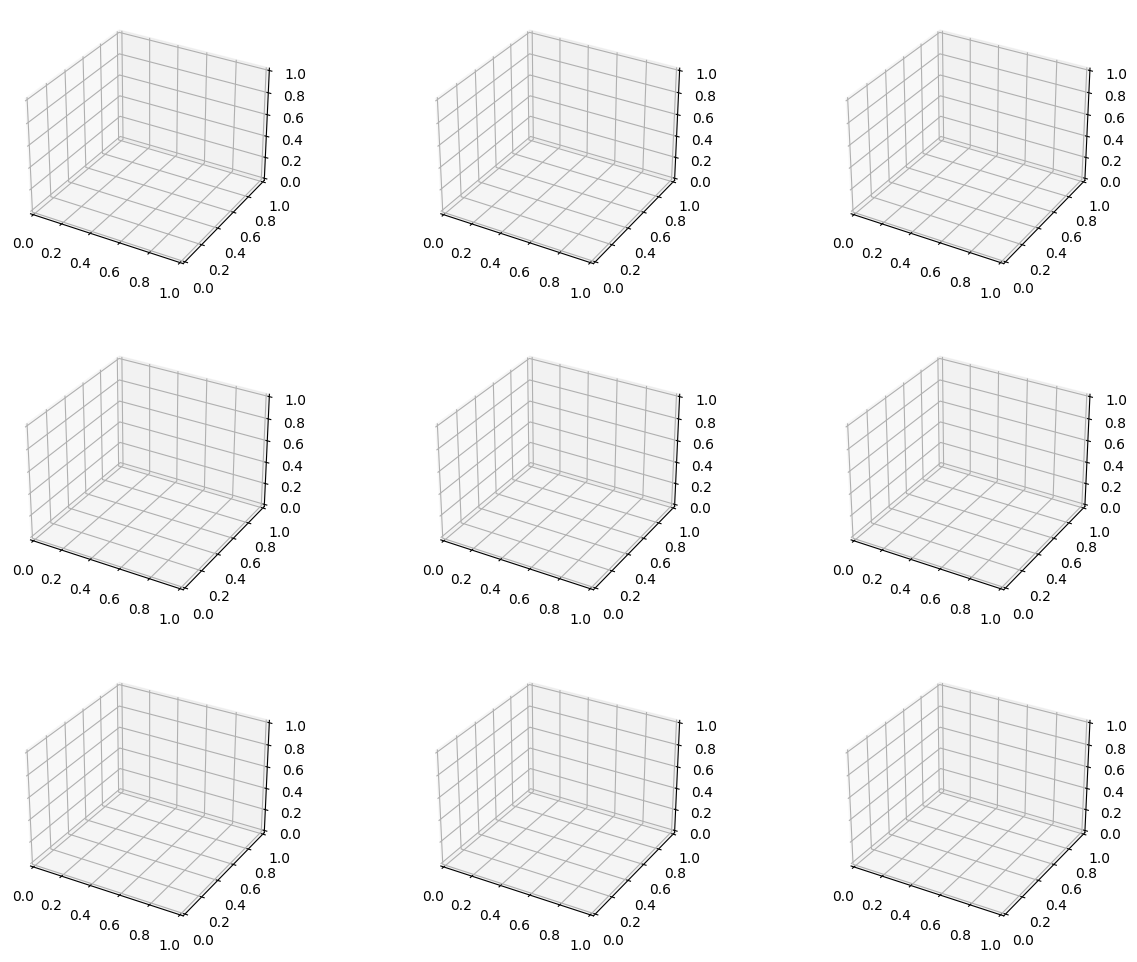

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

# 潜在変数リスト (例)
z_list = [
    torch.tensor([[ 1.6320981, -1.4126136 ]]),
    torch.tensor([[ -2.1357932,   0.59226215]]),
    torch.tensor([[ 1.271874,   -0.19390497]]),
    torch.tensor([[ 1.1243852,   0.75055796]]),
    torch.tensor([[ -0.11634811,  0.23012286]]),
    torch.tensor([[ -1.6708852,  -0.82595795]]),
    torch.tensor([[ -1.0746831,   1.4682127]]),
    torch.tensor([[ -0.2253337, -0.9014601]]),
    torch.tensor([[  0.6489936,   2.1788468]])
]

# 可視化用の設定
num_points = 1000  # 必要に応じて変更
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# GIF用フレームを保存するリスト
frames = []

# con_zを1.2から0.2まで0.1刻みに変化させる
con_z_values = np.arange(1.2, 0.1, -0.05)

# 再構築と可視化
for con_z in con_z_values:
    con_z_tensor = torch.tensor([con_z], dtype=torch.float32)

    # 各フレームごとに新しいプロットを作成
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
    axes = axes.flatten()

    for index, z in enumerate(z_list):
        if index >= len(axes):
            break  # プロット数を超えたら終了

        # zとcon_zをバッチ次元付きでdecodeに渡す
        in_z = z  # zはそのまま使用
        #print(z)
        # 再構築 (VAEモデルで実行)
        recon_batch = vae.decode(in_z, con_z_tensor)

        # CPU上で detach してから numpy() に変換
        reconst = recon_batch.cpu().detach().numpy().reshape(-1)

        # num_pointsに基づいて点群を分割
        reconst_x = reconst[:num_points]
        reconst_y = reconst[num_points:2*num_points]
        reconst_z = reconst[2*num_points:3*num_points]

        # プロット
        title = f"z1={z[0][0]:.2f}, z2={z[0][1]:.2f}, con_z={con_z:.2f}"
        axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1)
        axes[index].set_title(title)

    # レイアウトの調整
    plt.tight_layout()

    # フレームを保存するための一時的な画像ファイルに保存
    plt.savefig(f"/content/drive/MyDrive/chair/frame_{con_z:.2f}.png")

    # 画像を読み込んでframesに追加
    frames.append(imageio.imread(f"/content/drive/MyDrive/chair/frame_{con_z:.2f}.png"))

    # 現在のプロットをクリア
    plt.close()

# GIFアニメを作成して保存 (ループ設定)
imageio.mimsave('/content/drive/MyDrive/chair/CVAE_animation.gif', frames, fps=2, loop=0)

print("GIFアニメが生成されました。")
